In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, get_bounding_box_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,transform_box_from_world_to_sensor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion,Box
from lyft_dataset_sdk.utils.geometry_utils import points_in_box

In [80]:
from provider import FrustumDataset

In [81]:
lyft_data_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/artifact/lyft_val.pickle"
kitti_data_file="/Users/kanhua/Downloads/frustum-pointnets/kitti/frustum_carpedcyc_val.pickle"
NUM_POINT=1024

In [82]:
dataset=FrustumDataset(npoints=NUM_POINT,split='val',
                       from_rgb_detection=False,
                    overwritten_data_path=kitti_data_file,one_hot=True,rotate_to_center=True)

In [138]:
data_idx=30
dataset[data_idx]

(array([[-2.9007154 ,  1.1640935 , 15.137114  ,  0.5       ],
        [ 0.7117498 ,  0.46625662,  8.747478  ,  0.2       ],
        [-2.0206125 ,  1.7401458 , 12.862028  ,  0.36      ],
        ...,
        [-0.5891641 ,  0.72383   , 10.841864  ,  0.34      ],
        [-1.8025473 ,  1.7047104 , 13.092743  ,  0.31      ],
        [-0.7493008 ,  1.3203124 , 11.185232  ,  0.38      ]],
       dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.37371122, 0.985     , 3.95282683]),
 8,
 0.040044384519704046,
 0,
 array([-0.8031164 , -0.1885674 , -0.13563191]),
 0.5643507178734919,
 array([1., 0., 0.]))

In [139]:
def rad2deg(radius):
    return radius*180/np.pi

In [140]:
pointset=dataset[data_idx][0]
box3d_center=dataset[data_idx][2]

In [141]:
pointset_before_transformation=dataset.input_list[data_idx]

## Comparison before and after rotation

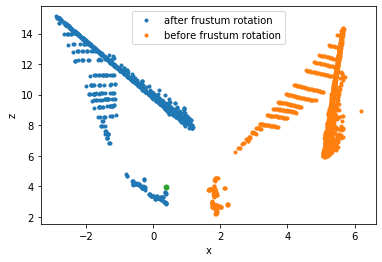

In [142]:
plt.plot(pointset[:,0],pointset[:,2],'.',label="after frustum rotation")
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.',label="before frustum rotation")
#plt.plot(pointset[seg,0],pointset[seg,2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
plt.xlabel("x")
plt.ylabel("z")
plt.legend()

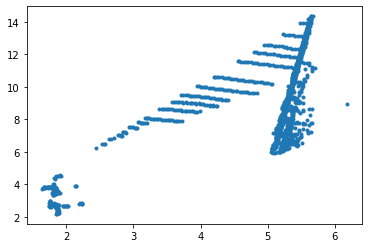

In [143]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')

In [144]:
dataset.id_list[data_idx]

25

## Plot box

In [145]:
def get_box_center(box_corners):
    box3d_center = (box_corners[0,:] + \
            box_corners[6,:])/2.0
    return box3d_center

In [146]:
box_3d_center_before_transformation=dataset.box3d_list[data_idx]
print("box center before transformation:",box_3d_center_before_transformation)
box_lwh=dataset.size_list[data_idx]
print("box size (lwh):",box_lwh)
heading_angle=dataset.heading_list[data_idx]
print("heading angle:",heading_angle)

box center before transformation: [[1.83663983 1.68       4.73308622]
 [3.27194219 1.68       4.61686606]
 [3.02336017 1.68       1.54691378]
 [1.58805781 1.68       1.66313394]
 [1.83663983 0.29       4.73308622]
 [3.27194219 0.29       4.61686606]
 [3.02336017 0.29       1.54691378]
 [1.58805781 0.29       1.66313394]]
box size (lwh): [3.08 1.44 1.39]
heading angle: -1.49


In [147]:
box3d_center=get_box_center(box_3d_center_before_transformation)

In [148]:
bounding_box_camera_coord=Box(center=box3d_center,size=[box_lwh[1],box_lwh[0],box_lwh[2]],
                             orientation=Quaternion(axis=[0,1,0],angle=heading_angle))

In [149]:
box_corners=bounding_box_camera_coord.corners()
box_corners=np.transpose(box_corners)

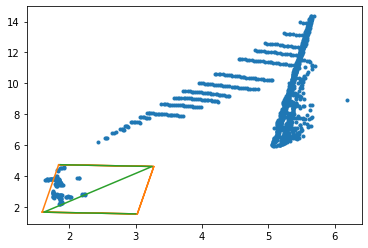

In [150]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(box_3d_center_before_transformation[:,0],box_3d_center_before_transformation[:,2])
plt.plot(box_corners[:,0],box_corners[:,2])

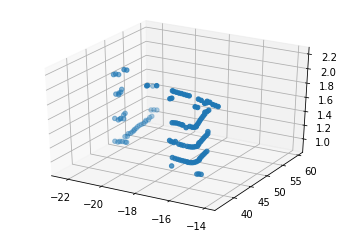

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(pointset_before_transformation[:,0],
           pointset_before_transformation[:,2],pointset_before_transformation[:,1])

In [45]:
sel_pointset=pointset[seg,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(sel_pointset[:,0],sel_pointset[:,2],sel_pointset[:,1])

NameError: name 'seg' is not defined

## See inference results

In [ ]:
import tensorflow as tf
import importlib
from train_util import get_batch
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
# Set training configurations
BATCH_SIZE = 1
MODEL_PATH = "/Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt"
GPU_INDEX = 0
MODEL = importlib.import_module("frustum_pointnets_v1")
NUM_CLASSES = 2
NUM_CHANNEL = 4

In [ ]:
# functions excerpted from frustum-pointnet test.py
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:' + str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape) - 1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape) - 1, keepdims=True)
    return probs


def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0] % batch_size == 0
    num_batches = int(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        feed_dict = { \
            ops['pointclouds_pl']: pc[i * batch_size:(i + 1) * batch_size, ...],
            ops['one_hot_vec_pl']: one_hot_vec[i * batch_size:(i + 1) * batch_size, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[i * batch_size:(i + 1) * batch_size, ...] = batch_logits
        centers[i * batch_size:(i + 1) * batch_size, ...] = batch_centers
        heading_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_scores
        heading_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_residuals
        size_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_size_scores
        size_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:, :, 1]  # BxN
        batch_seg_mask = np.argmax(batch_logits, 2)  # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1)  # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,
        heading_prob = np.max(softmax(batch_heading_scores), 1)  # B
        size_prob = np.max(softmax(batch_size_scores), 1)  # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i * batch_size:(i + 1) * batch_size] = batch_scores
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [ ]:
sess, ops = get_session_and_ops(batch_size=BATCH_SIZE, num_point=NUM_POINT)

In [ ]:
result_dir=None
TEST_DATASET=dataset

## Proecedures of test()
ps_list = []
seg_list = []
segp_list = []
center_list = []
heading_cls_list = []
heading_res_list = []
size_cls_list = []
size_res_list = []
rot_angle_list = []
score_list = []

test_idxs = np.arange(0, len(TEST_DATASET))
batch_size = BATCH_SIZE
num_batches = int(len(TEST_DATASET) / batch_size)
assert ((len(TEST_DATASET) % int(batch_size)) == 0)

sess, ops = get_session_and_ops(batch_size=batch_size, num_point=NUM_POINT)
correct_cnt = 0
for batch_idx in range(num_batches):
    #print('batch idx: %d' % (batch_idx))
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_data, batch_label, batch_center, \
    batch_hclass, batch_hres, batch_sclass, batch_sres, \
    batch_rot_angle, batch_one_hot_vec = \
        get_batch(TEST_DATASET, test_idxs, start_idx, end_idx,
                  NUM_POINT, NUM_CHANNEL)

    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
        inference(sess, ops, batch_data,
                  batch_one_hot_vec, batch_size=batch_size)

    correct_cnt += np.sum(batch_output == batch_label)

    for i in range(batch_output.shape[0]):
        ps_list.append(batch_data[i, ...])
        seg_list.append(batch_label[i, ...])
        segp_list.append(batch_output[i, ...])
        center_list.append(batch_center_pred[i, :])
        heading_cls_list.append(batch_hclass_pred[i])
        heading_res_list.append(batch_hres_pred[i])
        size_cls_list.append(batch_sclass_pred[i])
        size_res_list.append(batch_sres_pred[i, :])
        rot_angle_list.append(batch_rot_angle[i])
        score_list.append(batch_scores[i])

print("Segmentation accuracy: %f" % \
      (correct_cnt / float(batch_size * num_batches * NUM_POINT)))

In [ ]:
len(TEST_DATASET)

In [ ]:
score_list[0]

In [ ]:
segp_list[0]

In [ ]:
seg_list[0]

In [ ]:
np.sum(seg_list[1]==segp_list[1])/seg_list[1].shape

In [ ]:
data_idx=2
pointset=ps_list[data_idx]
plt.plot(pointset[:,0],pointset[:,2],'.')
#plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(pointset[segp_list[data_idx],0],pointset[segp_list[data_idx],2],'.')
plt.plot(pointset[seg_list[data_idx],0],pointset[seg_list[data_idx],2],'.')
#plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
#plt.ylim([4,6])
#plt.xlim([-1,1])

In [ ]:
15589/3

In [ ]:
center_list[data_idx]

In [ ]:
dataset[data_idx][2]